**This space is for testing how to concatenate different gene by cell matrices**

### Load necessary libraries and define useful functions

In [53]:
import scanpy as sc
import math
import bbknn
import warnings
import mnnpy
import numpy as np
warnings.filterwarnings('ignore')

# Basic filtering and transformation
def preprocess(annData):
    sc.pp.log1p(annData)
    sc.pp.filter_genes(annData, min_cells=int(annData.n_obs*0.05))
    sc.pp.filter_cells(annData, min_genes=5)
    sc.pp.highly_variable_genes(annData, flavor="seurat")
    sc.pp.normalize_total(annData, exclude_highly_expressed=True)

def merge_knn(*args):
    '''
    Wrapper for merging different datasets using batch balanced knn
    :param args: AnnDatas to merge
    :return: Concatenated AnnData
    '''

    annData = args[0].concatenate(args[1:], batch_key='knn_batch')

    sc.pp.log1p(annData)
    sc.pp.filter_genes(annData, min_cells=int(annData.n_obs * 0.05))
    sc.pp.filter_cells(annData, min_genes=5)
    sc.pp.highly_variable_genes(annData, flavor="seurat")
    sc.pp.normalize_total(annData, exclude_highly_expressed=True)
    sc.pp.pca(annData)
    sc.external.pp.bbknn(annData, batch_key='knn_batch', copy=False)

    return annData

def umap(annData):
    sc.pp.pca(annData)
    sc.pp.neighbors(annData)
    sc.tl.umap(annData)

### Read files

In [92]:
annData1 = '/Users/pgarcia-nietochanzuckerberg.com/projects/cell_type_transfer/pancreas/data/paper_alternative.loom'
annData2 = '/Users/pgarcia-nietochanzuckerberg.com/projects/cell_type_transfer/pancreas/data/paper_alternative_GSE86469.loom'
annData3 = '/Users/pgarcia-nietochanzuckerberg.com/projects/cell_type_transfer/pancreas/data/paper_alternative_GSE84133.loom'
annData4 = '/Users/pgarcia-nietochanzuckerberg.com/projects/cell_type_transfer/pancreas/data/hca_cellTypes.loom'


annData1 = sc.read(annData1)
annData2 = sc.read(annData2)
annData3 = sc.read(annData3)
annData4 = sc.read(annData4)


annData1.obs['study'] = 'a'
annData2.obs['study'] = 'b'
annData3.obs['study'] = 'c'
annData4.obs['study'] = 'd'



annData1.var_names_make_unique()
annData2.var_names_make_unique()
annData3.var_names_make_unique()
annData4.var_names_make_unique()


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Concatenating
#### Simplest method -- just concatenate

In [8]:
annData_conc = annData1.concatenate(annData2, annData3)
preprocess(annData_conc)
umap(annData_conc)

... storing 'Assay.Name' as categorical
... storing 'Characteristics.age.' as categorical
... storing 'Characteristics.body.mass.index.' as categorical
... storing 'Characteristics.cell.type.' as categorical
... storing 'Characteristics.disease.' as categorical
... storing 'Characteristics.individual.' as categorical
... storing 'Characteristics.organism.' as categorical
... storing 'Characteristics.organism.part.' as categorical
... storing 'Characteristics.sex.' as categorical
... storing 'Characteristics.single.cell.well.quality.' as categorical
... storing 'Comment..Derived.ArrayExpress.FTP.file.' as categorical
... storing 'Comment.BioSD_SAMPLE.' as categorical
... storing 'Comment.ENA_EXPERIMENT.' as categorical
... storing 'Comment.ENA_RUN.' as categorical
... storing 'Comment.ENA_SAMPLE.' as categorical
... storing 'Comment.FASTQ_URI.' as categorical
... storing 'Comment.LIBRARY_LAYOUT.' as categorical
... storing 'Comment.LIBRARY_SELECTION.' as categorical
... storing 'Comment

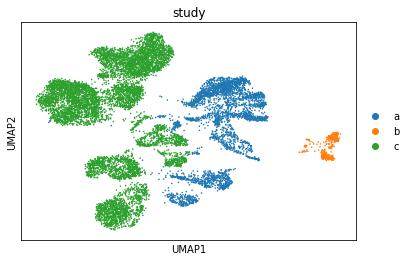

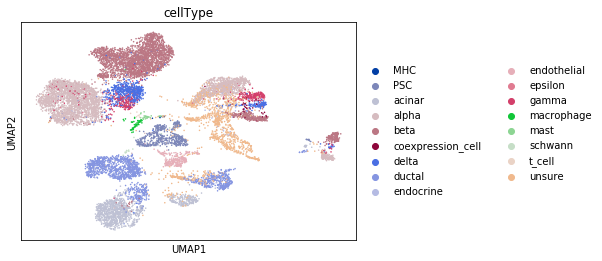

In [9]:
sc.pl.umap(annData_conc, color='study')
sc.pl.umap(annData_conc, color='cellType')


#### Batch balanced kNN 
This is taken from scanpy documentation:

*Batch balanced kNN alters the kNN procedure to identify each cell’s top neighbours in each batch separately instead of the entire cell pool with no accounting for batch. Aligns batches in a quick and lightweight manner.*

In [27]:
annData_kNN = annData1.concatenate(annData2, annData3)
preprocess(annData_kNN)
sc.pp.pca(annData_kNN)
annData_kNN_old = annData_kNN.copy()
sc.external.pp.bbknn(annData_kNN, batch_key='study', copy=False)

In [18]:
sc.tl.umap(annData_kNN)   

... storing 'Assay.Name' as categorical
... storing 'Characteristics.age.' as categorical
... storing 'Characteristics.body.mass.index.' as categorical
... storing 'Characteristics.cell.type.' as categorical
... storing 'Characteristics.disease.' as categorical
... storing 'Characteristics.individual.' as categorical
... storing 'Characteristics.organism.' as categorical
... storing 'Characteristics.organism.part.' as categorical
... storing 'Characteristics.sex.' as categorical
... storing 'Characteristics.single.cell.well.quality.' as categorical
... storing 'Comment..Derived.ArrayExpress.FTP.file.' as categorical
... storing 'Comment.BioSD_SAMPLE.' as categorical
... storing 'Comment.ENA_EXPERIMENT.' as categorical
... storing 'Comment.ENA_RUN.' as categorical
... storing 'Comment.ENA_SAMPLE.' as categorical
... storing 'Comment.FASTQ_URI.' as categorical
... storing 'Comment.LIBRARY_LAYOUT.' as categorical
... storing 'Comment.LIBRARY_SELECTION.' as categorical
... storing 'Comment

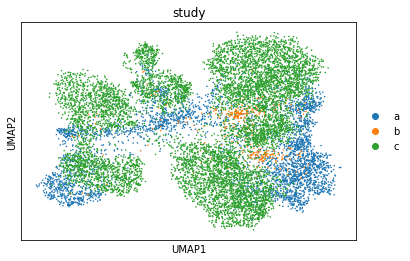

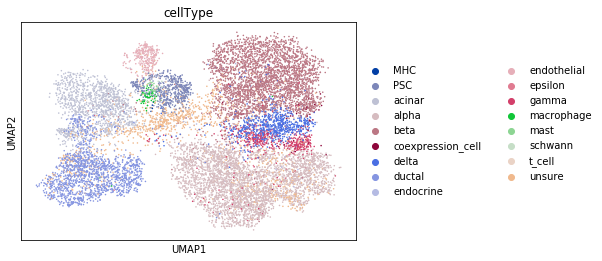

In [19]:
sc.pl.umap(annData_kNN, color='study')
sc.pl.umap(annData_kNN, color='cellType')

In [36]:
print(annData_kNN.X[:20,:20])
print("hola")
print(annData_kNN_old.X[:20, :20])

  (1, 15)	2.9439685
  (2, 15)	2.2229273
  (2, 17)	2.2229273
  (2, 18)	2.2229273
  (4, 9)	0.67755634
  (4, 10)	0.67755634
  (4, 15)	1.0739014
  (4, 16)	0.67755634
  (4, 17)	1.0739014
  (4, 18)	0.67755634
  (5, 0)	0.57342094
  (5, 2)	0.28671047
  (5, 9)	0.57342094
  (5, 14)	0.57342094
  (5, 18)	0.28671047
  (5, 19)	0.57342094
  (6, 9)	0.56223977
  (6, 13)	0.759237
  (6, 14)	0.7539627
  (6, 16)	0.6941627
  (6, 17)	0.87555754
  (7, 2)	0.3592804
  (7, 9)	0.43306893
  (7, 10)	0.39541408
  (7, 13)	0.62077236
  :	:
  (16, 15)	0.1275037
  (16, 16)	0.2550074
  (16, 17)	0.6062657
  (16, 18)	0.45709598
  (17, 2)	0.20000759
  (17, 9)	0.44533
  (17, 16)	0.39494216
  (17, 17)	0.58637583
  (17, 18)	0.5148744
  (17, 19)	0.5535493
  (18, 0)	0.18900107
  (18, 2)	0.4388469
  (18, 9)	0.5670032
  (18, 10)	0.5991192
  (18, 13)	0.53059304
  (18, 14)	0.4388469
  (18, 17)	0.7725348
  (18, 18)	0.7195941
  (19, 2)	0.29354745
  (19, 9)	0.4855789
  (19, 14)	0.20912744
  (19, 15)	0.62013996
  (19, 17)	0.6099087
  (1

In [37]:
annData_kNN.uns['neighbors']

{'params': {'n_neighbors': 9, 'method': 'umap'},
 'distances': <12463x12463 sparse matrix of type '<class 'numpy.float64'>'
 	with 99735 stored elements in Compressed Sparse Row format>,
 'connectivities': <12463x12463 sparse matrix of type '<class 'numpy.float64'>'
 	with 109733 stored elements in Compressed Sparse Row format>}

#### Matching mutual nearest neighbors
This is taken from scanpy documentation:


*Correct batch effects by matching mutual nearest neighbors [Haghverdi18] [Kang18].*

*This uses the implementation of mnnpy [Kang18].*

*Depending on do_concatenate, returns matrices or AnnData objects in the original order containing corrected expression values or a concatenated matrix or AnnData object.*

*Be reminded that it is not advised to use the corrected data matrices for differential expression testing.*

In [ ]:
annData_conc_2 = annData1.concatenate(annData3)
annData_mnn, mnn_list, angle_list = sc.external.pp.mnn_correct(annData1[:,annData_conc_2.var_names], 
                                                               annData3[:,annData_conc_2.var_names],
                                                               batch_key='study')

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...


In [ ]:
umap(annData_mnn)

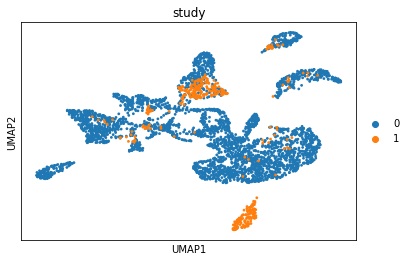

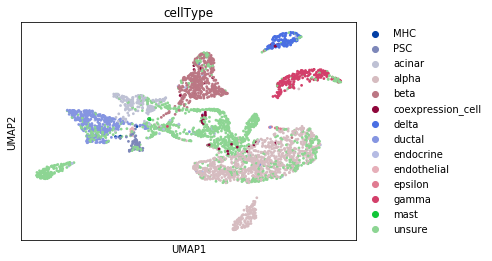

In [41]:
sc.pl.umap(annData_mnn, color='study')
sc.pl.umap(annData_mnn, color='cellType')

#### Combat
This is taken from scanpy documentation:


*ComBat function for batch effect correction [Johnson07] [Leek12] [Pedersen12].*

*Corrects for batch effects by fitting linear models, gains statistical power via an EB framework where information is borrowed across genes. This uses the implementation of ComBat [Pedersen12].*

##### ComBat alone

... storing 'Assay.Name' as categorical
... storing 'Characteristics.age.' as categorical
... storing 'Characteristics.body.mass.index.' as categorical
... storing 'Characteristics.cell.type.' as categorical
... storing 'Characteristics.disease.' as categorical
... storing 'Characteristics.individual.' as categorical
... storing 'Characteristics.organism.' as categorical
... storing 'Characteristics.organism.part.' as categorical
... storing 'Characteristics.sex.' as categorical
... storing 'Characteristics.single.cell.well.quality.' as categorical
... storing 'Comment..Derived.ArrayExpress.FTP.file.' as categorical
... storing 'Comment.BioSD_SAMPLE.' as categorical
... storing 'Comment.ENA_EXPERIMENT.' as categorical
... storing 'Comment.ENA_RUN.' as categorical
... storing 'Comment.ENA_SAMPLE.' as categorical
... storing 'Comment.FASTQ_URI.' as categorical
... storing 'Comment.LIBRARY_LAYOUT.' as categorical
... storing 'Comment.LIBRARY_SELECTION.' as categorical
... storing 'Comment

Found 321 genes with zero variance.


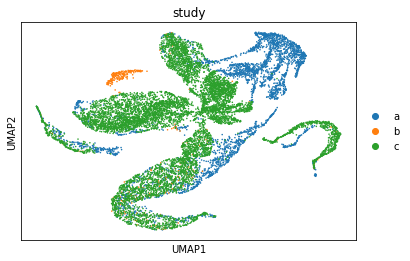

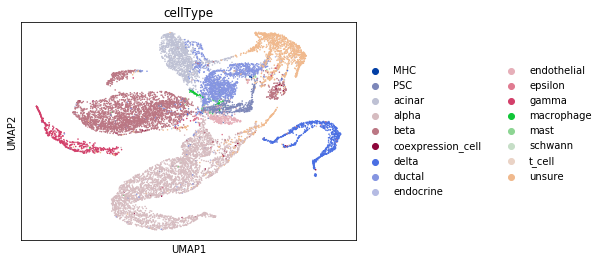

In [88]:
annData_conc_2 = annData1.concatenate(annData2, annData3)

sc.pp.combat(annData_conc_2, key='study', covariates=None, inplace=True)

umap(annData_conc_2)
sc.pl.umap(annData_conc_2, color='study')
sc.pl.umap(annData_conc_2, color='cellType')

##### ComBat alone with preprocessing on the concatenated data

... storing 'Assay.Name' as categorical
... storing 'Characteristics.age.' as categorical
... storing 'Characteristics.body.mass.index.' as categorical
... storing 'Characteristics.cell.type.' as categorical
... storing 'Characteristics.disease.' as categorical
... storing 'Characteristics.individual.' as categorical
... storing 'Characteristics.organism.' as categorical
... storing 'Characteristics.organism.part.' as categorical
... storing 'Characteristics.sex.' as categorical
... storing 'Characteristics.single.cell.well.quality.' as categorical
... storing 'Comment..Derived.ArrayExpress.FTP.file.' as categorical
... storing 'Comment.BioSD_SAMPLE.' as categorical
... storing 'Comment.ENA_EXPERIMENT.' as categorical
... storing 'Comment.ENA_RUN.' as categorical
... storing 'Comment.ENA_SAMPLE.' as categorical
... storing 'Comment.FASTQ_URI.' as categorical
... storing 'Comment.LIBRARY_LAYOUT.' as categorical
... storing 'Comment.LIBRARY_SELECTION.' as categorical
... storing 'Comment

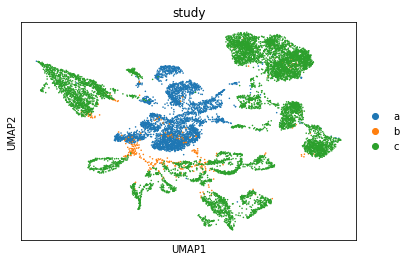

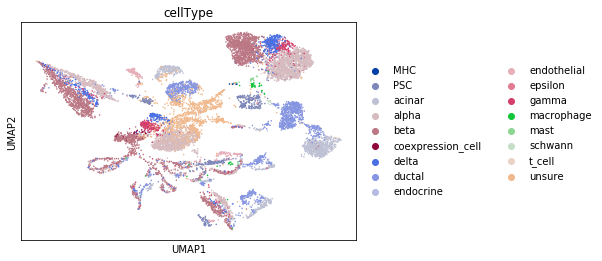

In [85]:
annData_conc_2 = annData1.concatenate(annData2, annData3)
preprocess(annData_conc_2)
##### ComBat alone
sc.pp.combat(annData_conc_2, key='study', covariates=None, inplace=True)

umap(annData_conc_2)
sc.pl.umap(annData_conc_2, color='study')
sc.pl.umap(annData_conc_2, color='cellType')

##### ComBat & highly variable genes

... storing 'Assay.Name' as categorical
... storing 'Characteristics.age.' as categorical
... storing 'Characteristics.body.mass.index.' as categorical
... storing 'Characteristics.cell.type.' as categorical
... storing 'Characteristics.disease.' as categorical
... storing 'Characteristics.individual.' as categorical
... storing 'Characteristics.organism.' as categorical
... storing 'Characteristics.organism.part.' as categorical
... storing 'Characteristics.sex.' as categorical
... storing 'Characteristics.single.cell.well.quality.' as categorical
... storing 'Comment..Derived.ArrayExpress.FTP.file.' as categorical
... storing 'Comment.BioSD_SAMPLE.' as categorical
... storing 'Comment.ENA_EXPERIMENT.' as categorical
... storing 'Comment.ENA_RUN.' as categorical
... storing 'Comment.ENA_SAMPLE.' as categorical
... storing 'Comment.FASTQ_URI.' as categorical
... storing 'Comment.LIBRARY_LAYOUT.' as categorical
... storing 'Comment.LIBRARY_SELECTION.' as categorical
... storing 'Comment

Found 321 genes with zero variance.


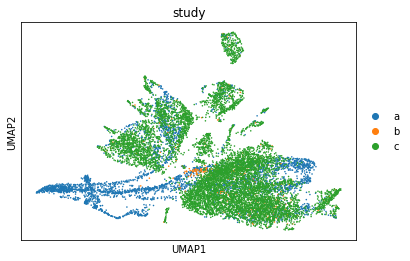

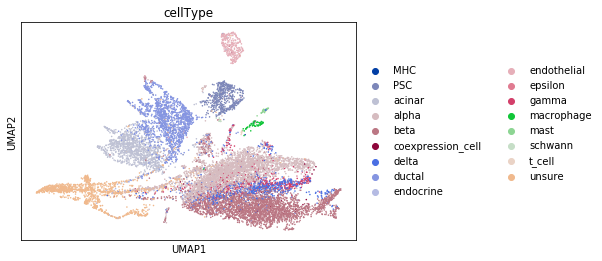

In [86]:
annData_conc_2 = annData1.concatenate(annData2, annData3)
sc.pp.combat(annData_conc_2, key='study', covariates=None, inplace=True)

sc.pp.highly_variable_genes(annData_conc_2, flavor="cell_ranger")
umap(annData_conc_2)
sc.pl.umap(annData_conc_2, color='study')
sc.pl.umap(annData_conc_2, color='cellType')

##### ComBat & highly variable genes & filter genes & filter cells

... storing 'Assay.Name' as categorical
... storing 'Characteristics.age.' as categorical
... storing 'Characteristics.body.mass.index.' as categorical
... storing 'Characteristics.cell.type.' as categorical
... storing 'Characteristics.disease.' as categorical
... storing 'Characteristics.individual.' as categorical
... storing 'Characteristics.organism.' as categorical
... storing 'Characteristics.organism.part.' as categorical
... storing 'Characteristics.sex.' as categorical
... storing 'Characteristics.single.cell.well.quality.' as categorical
... storing 'Comment..Derived.ArrayExpress.FTP.file.' as categorical
... storing 'Comment.BioSD_SAMPLE.' as categorical
... storing 'Comment.ENA_EXPERIMENT.' as categorical
... storing 'Comment.ENA_RUN.' as categorical
... storing 'Comment.ENA_SAMPLE.' as categorical
... storing 'Comment.FASTQ_URI.' as categorical
... storing 'Comment.LIBRARY_LAYOUT.' as categorical
... storing 'Comment.LIBRARY_SELECTION.' as categorical
... storing 'Comment

Found 321 genes with zero variance.


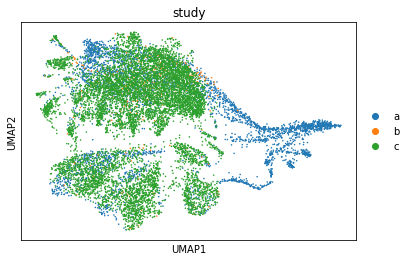

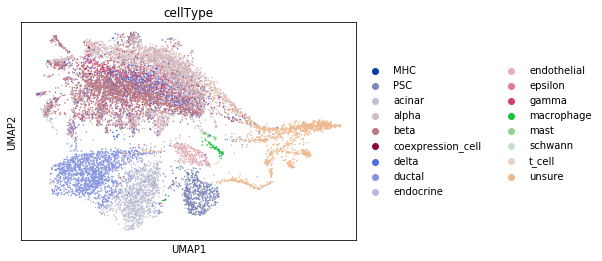

In [87]:
annData_conc_2 = annData1.concatenate(annData2, annData3)
sc.pp.combat(annData_conc_2, key='study', covariates=None, inplace=True)

#preprocess(annData_conc_2)
#sc.pp.log1p(annData_conc_2)
sc.pp.filter_genes(annData_conc_2, min_cells=int(annData_conc_2.n_obs*0.05))
sc.pp.filter_cells(annData_conc_2, min_genes=5)
sc.pp.highly_variable_genes(annData_conc_2, flavor="cell_ranger")
#sc.pp.normalize_total(annData_conc_2, exclude_highly_expressed=True)
#umap(annData_conc_2)


umap(annData_conc_2)
sc.pl.umap(annData_conc_2, color='study')
sc.pl.umap(annData_conc_2, color='cellType')

Making variable names unique for controlled concatenation.
... storing 'Assay.Name' as categorical
... storing 'Characteristics.age.' as categorical
... storing 'Characteristics.body.mass.index.' as categorical
... storing 'Characteristics.cell.type.' as categorical
... storing 'Characteristics.disease.' as categorical
... storing 'Characteristics.individual.' as categorical
... storing 'Characteristics.organism.' as categorical
... storing 'Characteristics.organism.part.' as categorical
... storing 'Characteristics.sex.' as categorical
... storing 'Characteristics.single.cell.well.quality.' as categorical
... storing 'Comment..Derived.ArrayExpress.FTP.file.' as categorical
... storing 'Comment.BioSD_SAMPLE.' as categorical
... storing 'Comment.ENA_EXPERIMENT.' as categorical
... storing 'Comment.ENA_RUN.' as categorical
... storing 'Comment.ENA_SAMPLE.' as categorical
... storing 'Comment.FASTQ_URI.' as categorical
... storing 'Comment.LIBRARY_LAYOUT.' as categorical
... storing 'Comm

Found 180 genes with zero variance.


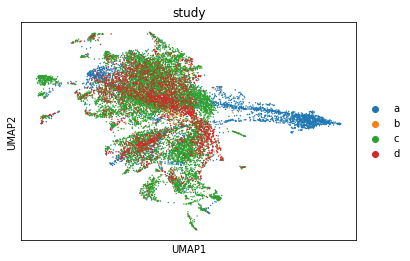

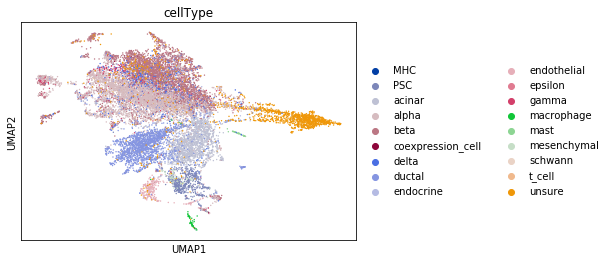

In [93]:
annData_conc_2 = annData1.concatenate(annData2, annData3, annData4)
sc.pp.combat(annData_conc_2, key='study', covariates=None, inplace=True)

#preprocess(annData_conc_2)
#sc.pp.log1p(annData_conc_2)
sc.pp.filter_genes(annData_conc_2, min_cells=int(annData_conc_2.n_obs*0.05))
sc.pp.filter_cells(annData_conc_2, min_genes=5)
sc.pp.highly_variable_genes(annData_conc_2, flavor="cell_ranger")
#sc.pp.normalize_total(annData_conc_2, exclude_highly_expressed=True)
#umap(annData_conc_2)


umap(annData_conc_2)
sc.pl.umap(annData_conc_2, color='study')
sc.pl.umap(annData_conc_2, color='cellType')